Aim: To classify a tweet as having positive or negative sentiment.

A set of actual tweets will be vectorized with the help of Natural Language Processing. Then modeling techniques will be used to classify them as either positive or negative.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%load_ext autoreload
%autoreload 2

reading the csv file using pandas

In [3]:
df = pd.read_csv('../../data/judge-1377884607_tweet_product_company.csv',
                 encoding='unicode_escape',
                 header=0,
                 names=['tweet_text', 'brand', 'emotion'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text    9092 non-null object
brand         3291 non-null object
emotion       9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


1 tweet_text has a NaN value and majority of brand entries are missing...

In [5]:
df.head()

,tweet_text,brand,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Let's Explore the data and identify the unique entries for product(`brand`) and sentiments(`emotion`).

In [6]:
df.brand.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [7]:
df.emotion.unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [8]:
apple_list = ['iPhone', 'iPad or iPhone App','iPad','Apple','Other Apple product or service']
google_list = ['Google', 'Android', 'Android App', 'Other Google product or service']

def brand_name(row):
    if row in apple_list:
        return 'Apple'
    elif row in google_list:
        return 'Google'
    else:
        return np.nan

Mapping apple products to Apple and android/google products to Google

In [9]:
df.brand = df.brand.map(brand_name)

In [10]:
df.brand.value_counts()

Apple     2409
Google     882
Name: brand, dtype: int64

In [11]:
df.emotion.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [12]:
def emotion_name(row):
    if row == 'Positive emotion':
        return 'Positive'
    elif row == 'Negative emotion':
        return 'Negative'
    else:
        return 'Neutral_or_unknown'

In [13]:
df.emotion = df.emotion.map(emotion_name)

In [14]:
df.emotion.value_counts(sort=False)

Positive              2978
Negative               570
Neutral_or_unknown    5545
Name: emotion, dtype: int64

Let's visualize how the target is distributed with respect to the brands in our dataset

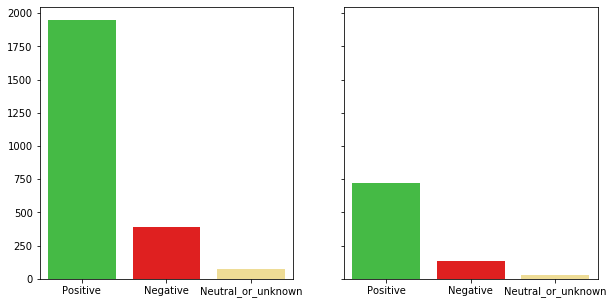

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)
for idx, brand in enumerate(['Apple', 'Google']):
    plot_data = df[df['brand'] == brand].emotion.value_counts()
    sns.barplot(x=plot_data.index, y=plot_data.values, ax=ax[idx], palette=['limegreen', 'red', '#FDE587'])
plt.show();

visualizing data for missing brand information

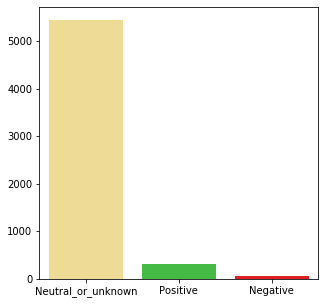

In [16]:
plt.figure(figsize=(5,5))
plot_data = df[df['brand'].isna()].emotion.value_counts()
sns.barplot(x=plot_data.index, y=plot_data.values, palette=['#FDE587', 'limegreen', 'red']); 

In [17]:
df = df.dropna(subset=['tweet_text'])

In [21]:
df.head(10)

,tweet_text,brand,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Apple,Negative
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Apple,Positive
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Apple,Positive
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Apple,Negative
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,Neutral_or_unknown
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Google,Positive
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,Apple,Positive
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive
10,Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1. #fail,Google,Positive


In [19]:
pd.set_option('max_colwidth', 400)

In [33]:
df[(df.brand.isna()) & (df.emotion.isin(['Positive', 'Negative']))].head()

,tweet_text,brand,emotion
46,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link},NaN,Positive
64,Again? RT @mention Line at the Apple store is insane.. #sxsw,NaN,Negative
68,"Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw",NaN,Negative
103,Know that &quot;dataviz&quot; translates to &quot;satanic&quot; on an iPhone. I'm just sayin'. #sxsw,NaN,Negative
112,Spark for #android is up for a #teamandroid award at #SXSW read about it here: {link},NaN,Positive


357 entries that have missing brand values exhibit either a positive or negative emotion. From the tweet_text we can ascertain the brand being discussed about. If the text has either Apple, iPhone or iPad we'll assume the brand being discussed is Apple and if the text has either android or Google we can assume the brand to be Goo

In [34]:
missing_brand = df[(df.brand.isna()) & (df.emotion.isin(['Positive', 'Negative']))]

In [24]:
from re import search

In [59]:
search(r'Apple|iPad|iPhone', missing_brand.iloc[0, 0])

<_sre.SRE_Match object; span=(68, 74), match='iPhone'>

In [60]:
def brand_name(row):
    if search(r'Apple|iPad|iPhone', row['tweet_text']):
        return 'Apple'
    elif search(r'android|Google', row['tweet_text']):
        return 'Google'
    else:
        return np.nan

In [63]:
missing_brand['brand'] = missing_brand.apply(brand_name, axis=1)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
missing_brand

,tweet_text,brand,emotion
46,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link},Apple,Positive
64,Again? RT @mention Line at the Apple store is insane.. #sxsw,Apple,Negative
68,"Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw",Apple,Negative
103,Know that &quot;dataviz&quot; translates to &quot;satanic&quot; on an iPhone. I'm just sayin'. #sxsw,Apple,Negative
112,Spark for #android is up for a #teamandroid award at #SXSW read about it here: {link},Google,Positive
...,...,...,...
9011,apparently the line to get an iPad at the #sxsw store grew by 2 blocks to 5 blocks in the past 30 mins. WUT.,Apple,Positive
9043,"Hey is anyone doing #sxsw signing up for the group texting app, groupme? got it on my iphone, but no one else is on it, so....kinda useless.",NaN,Negative
9049,@mention you can buy my used iPad and I'll pick one up tomorrow ;-) #sxsw,Apple,Positive
9052,@mention You could buy a new iPad 2 tmrw at the Apple pop-up store at #sxsw: {link},Apple,Positive


tweet_text    Guys, if you ever plan on attending #SXSW, you need 4 things, skinny jeans, flannel shirt, beard and an iPad #imanoutcast...
brand                                                                                                                                  NaN
emotion                                                                                                                           Positive
Name: 9054, dtype: object

RT in a tweet_text relates to a retweet. 